In [31]:
# importing required libraries
import numpy as np
import torch
import torch.nn as nn


# Define Gram Matrix
class GramMatrix(nn.Module):
    def forward(self, input_tensor):
        batch_size, num_channels, height, width = input_tensor.size()
        reshaped_features = input_tensor.view(batch_size, num_channels, height * width)
        reshaped_features_transposed = reshaped_features.transpose(1, 2)
        gram_matrix = reshaped_features.bmm(reshaped_features_transposed) / (num_channels * height * width)
        return gram_matrix

class Model(nn.Module):

    def __init__(self, C, B=1):
        super(Model, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, C, C), requires_grad=True)
        self.G = torch.Tensor(B, C, C).requires_grad_()
        self.C = C
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.uniform_(0.0, 0.02)

    def setTarget(self, target):
        self.G = target

    def forward(self, X):
        # input X is a 3D feature map
        self.P = torch.bmm(self.weight.expand_as(self.G), self.G)
        return torch.bmm(self.P.transpose(1, 2).expand(X.size(0), self.C, self.C),
                         X.view(X.size(0), X.size(1), -1)).view_as(X)

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'N x ' + str(self.C) + ')'


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = kernel_size // 2
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out

## mappings for residual blocks
class Bottleneck(nn.Module):

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 norm_layer=nn.BatchNorm2d):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes*self.expansion,
                                            kernel_size=1, stride=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       ConvLayer(planes, planes, kernel_size=3, stride=stride)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(planes, planes*self.expansion, kernel_size=1,
                                 stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        if self.downsample is not None:
            residual = self.residual_layer(x)
        else:
            residual = x
        return residual + self.conv_block(x)


class UpBottleneck(nn.Module):

    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBottleneck, self).__init__()
        self.expansion = 4
        self.residual_layer = UpsampleConvLayer(inplanes, planes*self.expansion,
                                                kernel_size=1, stride=1,
                                                upsample=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       UpsampleConvLayer(planes, planes, kernel_size=3,
                                         stride=1, upsample=stride)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(planes, planes*self.expansion, kernel_size=1,
                                 stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.residual_layer(x) + self.conv_block(x)


class Net(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64,
                 norm_layer=nn.InstanceNorm2d, n_blocks=6, gpu_ids=[]):
        super(Net, self).__init__()
        self.gpu_ids = gpu_ids
        self.gram = GramMatrix()

        block = Bottleneck
        upblock = UpBottleneck
        expansion = 4

        model1 = []
        model1 += [ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                   norm_layer(64),
                   nn.ReLU(inplace=True),
                   block(64, 32, 2, 1, norm_layer),
                   block(32*expansion, ngf, 2, 1, norm_layer)]
        self.model1 = nn.Sequential(*model1)

        model = []
        self.ins = Model(ngf*expansion)
        model += [self.model1]
        model += [self.ins]

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None, norm_layer)]

        model += [upblock(ngf*expansion, 32, 2, norm_layer),
                  upblock(32*expansion, 16, 2, norm_layer),
                  norm_layer(16*expansion),
                  nn.ReLU(inplace=True),
                  ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        f = self.model1(Xs)
        G = self.gram(f)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)

In [35]:
#### Util functions

from PIL import Image

def load_rgb_image_as_tensor(filename, size=None, scale=None, maintain_aspect_ratio=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if maintain_aspect_ratio:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale), Image.ANTIALIAS))
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img

def save_rgb_image_from_tensor(tensor, filename, use_cuda=False):
    if use_cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)

def save_bgr_image_from_tensor(tensor, filename, use_cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    save_rgb_image_from_tensor(tensor, filename, use_cuda)

def preprocess_tensor_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

In [47]:
#### Download trained model from here and save in current directory
#### https://drive.google.com/file/d/1wVqOmcZ6Mn5ERklsUf6k55WJNLmaG3ZJ/view?usp=drive_link
#### Use this model directly in the below evaluation code

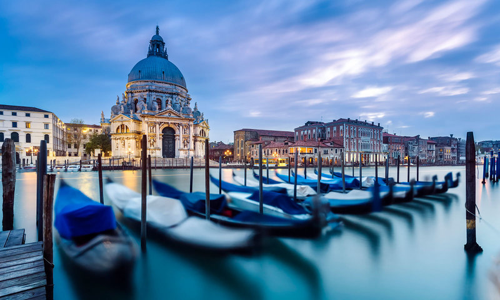

In [40]:
display(Image.open('content.jpg').resize((500, 300)))

In [43]:
content_image = load_rgb_image_as_tensor('content.jpg', size=512,
                                     maintain_aspect_ratio=True).unsqueeze(0)
style = load_rgb_image_as_tensor('style.jpg', size=512).unsqueeze(0)
style = preprocess_tensor_batch(style)

<ipython-input-35-af2af31bbfb9>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((size, size2), Image.ANTIALIAS)
<ipython-input-35-af2af31bbfb9>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((size, size), Image.ANTIALIAS)


In [44]:
style_model = Net(ngf=128)
model_dict = torch.load('style_transfer.model')
model_dict_clone = model_dict.copy()
for key, value in model_dict_clone.items():
    if key.endswith(('running_mean', 'running_var')):
        del model_dict[key]
style_model.load_state_dict(model_dict, False)

<All keys matched successfully>

In [45]:
content_image = preprocess_tensor_batch(content_image)
style_model.setTarget(style)
output = style_model(content_image)
save_bgr_image_from_tensor(output.data[0], 'output.jpg', False)

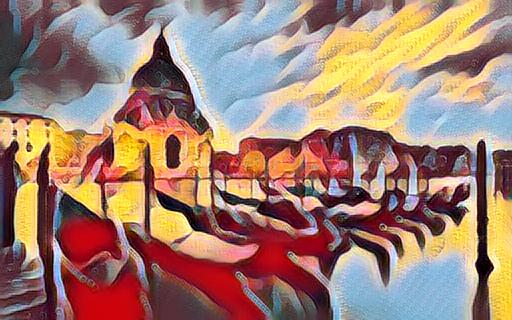

In [46]:
display(Image.open('output.jpg'))